## How to use DancePartner

DancePartner is a python package with the end goal of making multi-omics networks from literature. There are several functions that support the five main steps, which are to:

1. Select Papers

2. Identify Entities

3. Extract Relationships

4. Collapse Synonyms

5. Build Network

Here we will walk through all of the steps to build these networks, including each option and how to combine options. 

<img src="../ref_images/DancePartner_Banner.png">

In [1]:
import os
import shutil
import DancePartner as dance
import pandas as pd

# Define the output directory
output_directory = os.path.join(os.getcwd(), "full_pipeline_example")

# Remove it if it already exists and start anew
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
    os.mkdir(output_directory, mode = 0o777)
else: 
    os.mkdir(output_directory, mode = 0o777)

/Users/degn400/.virtualenvs/DancePartner/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-24 10:49:43 WE45748 metapub.config[20008] WARNING NCBI_API_KEY was not set.


## Step 1: Select Papers

There are two options for pulling papers. One is to use the `pull_papers()` function, and the other is to manually add publications. The second is to provide publications in text format within a file. Here, we will demonstrate the first option. For full details on this pipeline, see the "how_to_pull_papers" vignette. For simplicity, let's pull a few C. elegans publications. 

In [4]:
# Make a directory to hold papers
paper_directory = os.path.join(output_directory, "papers")
os.mkdir(paper_directory)

# Pull full text wherever available, and then titles and abstracts if full text is not available
dance.pull_papers(pubmed_ids = [37432911, 30788345, 35228596, 38563104, 36257965, 28734827, 30796049, 32291085, 33693628, 38964319], output_directory = paper_directory)

# Read summary file 
with open(os.path.join(paper_directory, "output_summary.txt"), "r") as f:
    print(f.read())

2025-04-24 10:50:16 WE45748 metapub.findit[20008] INFO FindIt Cache initialized at /Users/degn400/.cache/findit.db


Output Summary for Pulling Papers
Created: 2025-04-24 10:50:22.455226
Total Num. Articles: 10
Total Num. Articles Found: 10
Number of Full Text: 7
Number of Title & Abstracts: 3
Number Missing: 0



## Step 2: Identify Entities 

There are two methods for the identification of these entities.

1) AI: Using a ScispaCy model to label entities

2) Provide a list of terms of interest 

Here, we will demonstrate using the ScispaCy model `en_ner_bionlp13cg` and then provide a list of terms. Providing a list of terms is more than sufficient and ScispaCy is not necessary. For more details on the algorithm, see here: https://allenai.github.io/scispacy/ 

In [1]:
# Extract terms using AI model. Term identification will not be perfect, which will be corrected when matching terms to synonyms. 
output_directory = os.path.join(os.getcwd(), "full_pipeline_example")
paper_directory = os.path.join(output_directory, "papers")

my_terms = dance.extract_terms_scispacy(paper_directory, "../omes", verbose = True)
my_terms[0:10]

/Users/degn400/.virtualenvs/DancePartner/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-24 11:26:55 WE45748 metapub.config[25187] WARNING NCBI_API_KEY was not set.
/Users/degn400/.virtualenvs/DancePartner/lib/python3.9/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipeline_example/papers/pubmed_clean/35228596.txt
On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipeline_example/papers/pubmed_clean/30788345.txt
On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipeline_example/papers/pubmed_clean/33693628.txt
On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipeline_example/papers/pubmed_clean/36257965.txt
On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipeline_example/papers/pubmed_clean/38563104.txt
On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipeline_example/papers/pubmed_clean/30796049.txt
On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipeline_example/papers/pubmed_abstracts/32291085.txt
On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipeline_example/papers/pubmed_abstracts/28734827.txt
On paper... /Users/degn400/Git_Repos/DancePartner/vignettes/full_pipelin

['longterm',
 'alam g',
 'metab_fba',
 'ryu d',
 'hif1 target',
 's3c',
 '6758',
 'gse122902',
 'dnase',
 'tags']

Additionally, you can add terms from the general use metabolome and lipidome, or a specific proteome. Let's pull a proteome from UniProt for C. elegans. Find the correct UniProt ID here: https://www.uniprot.org/proteomes/. The name will start with "UP". Downstream functions will look for this file in the omes folder, so let's put it there.

In [2]:
dance.pull_proteome(proteome_id = "UP000001940", output_directory = "../omes")

Now let's extract all terms from the metabolome, lipidome, and proteome; and add them to our list. Stop words are pulled from the "stop_words_english.txt" file and can be modified at any time.

In [3]:
my_terms.extend(dance.list_synonyms("../omes", "UP000001940_proteome.txt"))

## Step 3: Extract Relationships

There are two methods for extracting relationships in literature. The first is to use an AI model, BERT, to determine if terms are related. The other is to pull information from databases, which does not use the mined literature. For the sake of this demo, we will pull these relationships after identifying synonyms in Step 4.

### Using BioBERT

First, we will identify sentences that contain terms of interest using `find_terms_in_papers`

In [4]:
output_directory = os.path.join(os.getcwd(), "full_pipeline_example")
paper_directory = os.path.join(output_directory, "papers")

dance.find_terms_in_papers(
    paper_directory = paper_directory,
    terms = my_terms,
    n_gram_max = 5,
    padding = 50,
    output_directory = output_directory
)
pairs = pd.read_csv(os.path.join(output_directory, "sentence_biomolecule_pairs.csv"))
pairs

,paper_id,term_1,term_2,id,sentence_index,segment_length,segment
0,28734827,hlh30,vit1,28734827,5,157,we further show that the size and number of in...
1,28734827,hlh30,vit1,28734827,4,158,we demonstrate that premature death of hlh30 a...
2,28734827,vit1,vit5,28734827,4,158,we demonstrate that premature death of hlh30 a...
3,28734827,hlh30,vit5,28734827,4,158,we demonstrate that premature death of hlh30 a...
4,30788345,figure s8,aac,30788345,285,171,e idh1 mutants glutamate become depleted in wo...
...,...,...,...,...,...,...,...
2936,38964319,laminin,nidogen,38964319,4,183,we show that membranematrix complexes containi...
2937,38964319,nidogen,laminin,38964319,9,151,unlike the basal lamina ensheathing the pharyn...
2938,38964319,mec4,nidogen,38964319,10,140,mec4 but not laminin or nidogen is destabilize...
2939,38964319,mec4,laminin,38964319,10,140,mec4 but not laminin or nidogen is destabilize...


Next, we can run the BERT model. Make sure to download the model from: https://huggingface.co/david-degnan/BioBERT-RE, and place it at the top level. At a minimum, the config.json, pytorch_model.bin, and training_args.bin files are needed.

In [1]:
import os
import shutil
import DancePartner as dance
import pandas as pd

# Define the output directory
output_directory = os.path.join(os.getcwd(), "full_pipeline_example")

dance.run_bert(input_path = os.path.join(output_directory, "sentence_biomolecule_pairs.csv"),
              model_path = "../biobert", # Update to the path of your BERT model if necessary. We recommend placing biobert in the top directory.
              output_directory = output_directory,
              segment_col_name = "segment",
              use_cpu = True)

/Users/degn400/.virtualenvs/DancePartner/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-24 11:44:27 WE45748 metapub.config[27400] WARNING NCBI_API_KEY was not set.


We can filter the BERT results down to true positives with a predicted probability of 0.5 or greater. 

In [2]:
# Define the output directory
output_directory = os.path.join(os.getcwd(), "full_pipeline_example")

# Pull all identified relationships and filter to the confirmed ones
BERT = pd.read_table(os.path.join(output_directory, "bert_results.txt"))
TrueBERT = BERT[BERT["True Positive"] >= 0.5]
TrueBERT

,paper_id,term_1,term_2,id,sentence_index,segment_length,Term1,Term2,Sentence,True Negative,True Positive
47,30788345,putrescine,cadaverine,30788345,197,208,@TERM$1,@TERM$2,@TERM$1 is metabolized from arginine via eit...,0.220556,0.779444
54,30788345,citrate,acetylcoa,30788345,205,167,@TERM$1,@TERM$2,levels with age figure s7b with the exception...,0.018497,0.981503
55,30788345,tca,citrate synthase,30788345,205,192,@TERM$1,@TERM$2,ysis indicated that most detected transcripts ...,0.080115,0.919885
57,30788345,synthase,oxaloacetate,30788345,205,159,@TERM$1,@TERM$2,with age figure s7b with the exception of citr...,0.010276,0.989724
65,30788345,tca,acetylcoa,30788345,205,243,@TERM$1,@TERM$2,ysis indicated that most detected transcripts ...,0.003068,0.996932
80,30788345,sadenosylmethioninamine,putrescine,30788345,200,194,@TERM$1,@TERM$2,this enzyme catalyzes the transfer of a polyam...,0.000036,0.999964
216,30788345,ampk,weir,30788345,320,230,@TERM$1,@TERM$2,it is not known however what triggers the loss...,0.000555,0.999445
299,30788345,fluxes,tca,30788345,245,234,@TERM$1,@TERM$2,when we included our metabolomics data as part...,0.294838,0.705162
485,30788345,isocitrate,dehydrogenase,30788345,147,124,@TERM$1,@TERM$2,sured in wild type n2 young adult animals lack...,0.001938,0.998062
715,30796049,ptx,methylxanthines,30796049,201,154,@TERM$1,@TERM$2,phylline amp enprofylline enpf and pentoxifyll...,0.223663,0.776337


## Step 4: Collapse Synonyms

We can now take the extracted terms and map synonyms to IDs. Let's first extract all the terms to map

In [3]:
# Pull terms 
all_found_terms = TrueBERT["term_1"].tolist()
all_found_terms.extend(TrueBERT["term_2"].to_list())
all_found_terms = list(set(all_found_terms))

Now let's map the synonyms.

In [4]:
dance.map_synonyms(
    term_list = all_found_terms,
    omes_folder = "../omes",
    proteome_filename = "UP000001940_proteome.txt",
    add_missing = True,
    output_directory = output_directory
)
synonyms = pd.read_csv(os.path.join(output_directory, "synonym_table.txt"), sep = "\t")
synonyms

,Synonym,ID,Type
0,acetylcoa,LMFA07050281,lipid
1,age1,Q94125,gene product
2,atp,CHEBI:15422,metabolite
3,cadaverine,CHEBI:18127,metabolite
4,citrate,CHEBI:16947,metabolite
...,...,...,...
59,pka,NaN,NaN
60,egl9,NaN,NaN
61,t246,NaN,NaN
62,pck1,NaN,NaN


Note that labeling is not perfect, as there are incorrectly labeled biomolecules and biomolecules that are missing. Here, we suggest users manually double check these annotations and clean them appropriately. For the sake of this demo, we will proceed. 

To see how to **pull relationships from databases**, go to step 5. 

## Step 5 Build Network

We can construct a network table. 

In [5]:
network_table = dance.build_network_table(TrueBERT, synonyms)
network_table

,Synonym1,ID1,Type1,Synonym2,ID2,Type2,Source
0,putrescine,CHEBI:17148,metabolite,cadaverine,CHEBI:18127,metabolite,literature
1,citrate,CHEBI:16947,metabolite,acetylcoa,LMFA07050281,lipid,literature
2,synthase,G5EDZ2,gene product,oxaloacetate,CHEBI:16452,metabolite,literature
3,tca,LMST05040001,lipid,acetylcoa,LMFA07050281,lipid,literature
4,sadenosylmethioninamine,CHEBI:15625,metabolite,putrescine,CHEBI:17148,metabolite,literature
5,lvaline,CHEBI:16414,metabolite,thiamin,CHEBI:18385,metabolite,literature
6,malate,CHEBI:15595,metabolite,tca,LMST05040001,lipid,literature
7,quinone,CHEBI:16509,metabolite,oxidoreductase,Q11190,gene product,literature
8,synthase,G5EDZ2,gene product,oxidoreductase,Q11190,gene product,literature
9,nadph,CHEBI:16474,metabolite,ribose5phosphate,CHEBI:17797,metabolite,literature


### Using Databases

We can pull additional relationships from the following databases: UniProt Interactions, Wikipathways, KEGG, and LipidMaps.

For a full tutorial, please see the `how_to_pull_from_databases` vignette

**UniProt Protein-Biomolecule Interactions**

In [6]:
dance.pull_uniprot(6239, output_directory, verbose = True)

mapped_terms = network_table["ID1"].tolist()
mapped_terms.extend(network_table["ID2"].tolist())

uniprot = pd.read_csv(os.path.join(output_directory, "6239_uniprot.txt"), sep = "\t")
uniprot = uniprot[uniprot["ID1"].isin(mapped_terms) | uniprot["ID2"].isin(mapped_terms)]
uniprot

...pulling organism metadata
...parsing protein-protein relationships
...parsing protein-metabolite relationships


,Synonym1,ID1,Type1,Synonym2,ID2,Type2,Source
1224,Not needed,Q11190,gene product,Not needed,CHEBI:49883,metabolite,database
1225,Not needed,Q11190,gene product,Not needed,CHEBI:57692,metabolite,database


### Visualizing Networks

We can combine network tables.

In [7]:
full_table = pd.concat([
    network_table,
    uniprot
]).reset_index(drop = True)
full_table

,Synonym1,ID1,Type1,Synonym2,ID2,Type2,Source
0,putrescine,CHEBI:17148,metabolite,cadaverine,CHEBI:18127,metabolite,literature
1,citrate,CHEBI:16947,metabolite,acetylcoa,LMFA07050281,lipid,literature
2,synthase,G5EDZ2,gene product,oxaloacetate,CHEBI:16452,metabolite,literature
3,tca,LMST05040001,lipid,acetylcoa,LMFA07050281,lipid,literature
4,sadenosylmethioninamine,CHEBI:15625,metabolite,putrescine,CHEBI:17148,metabolite,literature
5,lvaline,CHEBI:16414,metabolite,thiamin,CHEBI:18385,metabolite,literature
6,malate,CHEBI:15595,metabolite,tca,LMST05040001,lipid,literature
7,quinone,CHEBI:16509,metabolite,oxidoreductase,Q11190,gene product,literature
8,synthase,G5EDZ2,gene product,oxidoreductase,Q11190,gene product,literature
9,nadph,CHEBI:16474,metabolite,ribose5phosphate,CHEBI:17797,metabolite,literature


And finally, we can visualize the network.

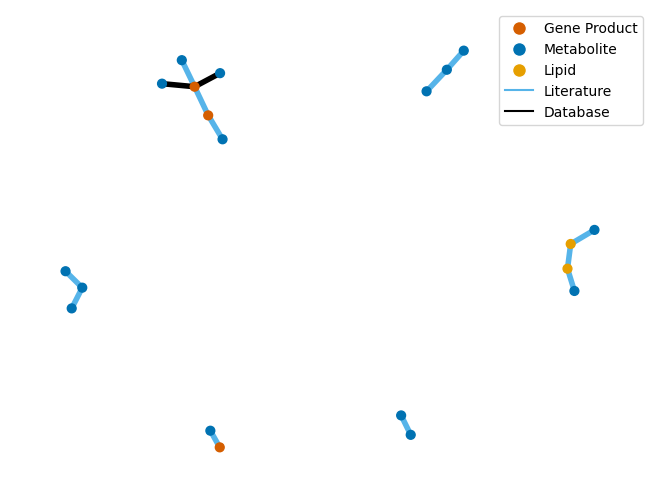

In [8]:
dance.visualize_network(full_table, node_size = 40)

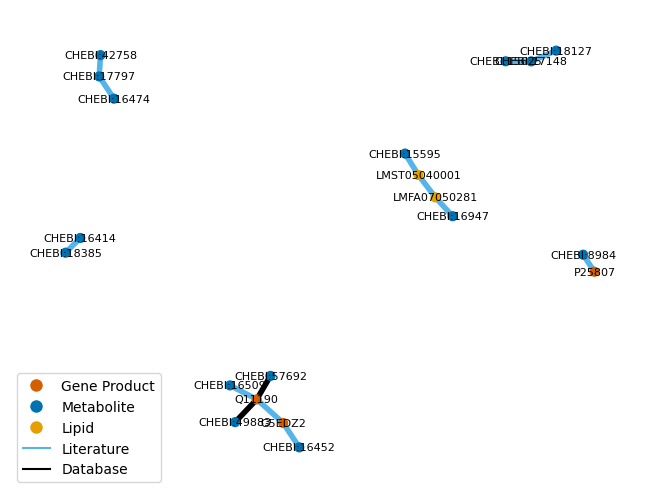

In [9]:
network = dance.visualize_network(full_table, node_size = 40, with_labels = True)

In [10]:
dance.calculate_network_metrics(network)

{'Number of Components': 6,
 'Average Component Size': 3.3333,
 'Degree Centrality':             Node  Centrality
 0         Q11190    0.210526
 1         G5EDZ2    0.105263
 2    CHEBI:17148    0.105263
 3   LMFA07050281    0.105263
 4    CHEBI:17797    0.105263
 5   LMST05040001    0.105263
 6         P25807    0.052632
 7    CHEBI:16947    0.052632
 8    CHEBI:16414    0.052632
 9    CHEBI:57692    0.052632
 10   CHEBI:16509    0.052632
 11   CHEBI:42758    0.052632
 12   CHEBI:16474    0.052632
 13   CHEBI:18385    0.052632
 14    CHEBI:8984    0.052632
 15   CHEBI:15595    0.052632
 16   CHEBI:18127    0.052632
 17   CHEBI:16452    0.052632
 18   CHEBI:15625    0.052632
 19   CHEBI:49883    0.052632,
 'Clustering Coefficient': 0.0}